In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap

## PART A

In [3]:
df = pd.read_csv('csv_result-file2754771351f4.csv')

In [4]:
df.head()

,id,'Att1','Att2','Att3','Att4','Att5','Att6','Att7','Att8','Att9',...,'Class5','Class6','Class7','Class8','Class9','Class10','Class11','Class12','Class13','Class14'
0,1,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,...,False,False,True,True,False,False,False,True,True,False
1,2,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,...,False,False,False,False,False,False,False,False,False,False
2,3,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,...,False,False,False,False,False,False,False,True,True,False
3,4,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,...,False,False,False,False,False,False,False,False,False,False
4,5,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,...,True,True,False,False,False,False,False,False,False,False


In [5]:
df = df.drop(columns='id')

In [6]:
df.isnull().sum()

'Att1'       0
'Att2'       0
'Att3'       0
'Att4'       0
'Att5'       0
            ..
'Class10'    0
'Class11'    0
'Class12'    0
'Class13'    0
'Class14'    0
Length: 117, dtype: int64

In [7]:
feature_matrix = df[df.columns[:103]]

In [8]:
label_matrix = df[df.columns[103:]]

In [9]:
feature_matrix.shape

(2417, 103)

In [10]:
def create_coloring_target_detailed(label_matrix):
    """
    Enhanced version with more detailed analysis
    """
    print("Original label matrix shape:", label_matrix.shape)
    print("\nOriginal label distribution (sum by column):")
    print(label_matrix.sum().sort_values(ascending=False))
    
    # Calculate number of labels per instance
    labels_per_instance = label_matrix.sum(axis=1)
    print(f"\nLabels per instance distribution:")
    print(labels_per_instance.value_counts().sort_index())
    
    # Get single-label instances
    single_label_mask = labels_per_instance == 1
    single_label_data = label_matrix[single_label_mask]
    
    # Find top single labels
    single_label_sums = single_label_data.sum().sort_values(ascending=False)
    top_single_labels = single_label_sums.head(2).index.tolist()
    
    print(f"\nTop 2 single labels: {top_single_labels}")
    
    # Get multi-label instances
    multi_label_mask = labels_per_instance > 1
    multi_label_data = label_matrix[multi_label_mask]
    
    # Convert to tuples for counting combinations
    multi_label_combinations = multi_label_data.apply(tuple, axis=1)
    combo_counts = multi_label_combinations.value_counts()
    
    if not combo_counts.empty:
        top_multi_combo = combo_counts.index[0]
        top_multi_count = combo_counts.iloc[0]
        print(f"Top multi-label combination: {top_multi_combo} (count: {top_multi_count})")
    else:
        top_multi_combo = None
        print("No multi-label instances found")
    
    # Create new target variable
    new_target = []
    
    for idx, row in label_matrix.iterrows():
        label_tuple = tuple(row.astype(int))
        num_labels = sum(label_tuple)
        
        if num_labels == 1:  # Single label
            active_label = row[row == 1].index[0]
            if active_label in top_single_labels:
                new_target.append(f"Single_{active_label}")
            else:
                new_target.append("Other")
        
        elif num_labels > 1:  # Multi-label
            if label_tuple == top_multi_combo:
                active_labels = [i+1 for i, val in enumerate(label_tuple) if val == 1]
                new_target.append(f"Multi_{'_'.join(map(str, active_labels))}")
            else:
                new_target.append("Other")
        
        else:  # No labels
            new_target.append("Other")
    
    target_series = pd.Series(new_target, index=label_matrix.index)
    
    print(f"\nNew target distribution:")
    print(target_series.value_counts())
    
    return target_series, top_single_labels, top_multi_combo

# Usage:
new_target, top_singles, top_multi = create_coloring_target_detailed(label_matrix)

Original label matrix shape: (2417, 14)

Original label distribution (sum by column):
'Class12'    1816
'Class13'    1799
'Class2'     1038
'Class3'      983
'Class4'      862
'Class1'      762
'Class5'      722
'Class6'      597
'Class8'      480
'Class7'      428
'Class11'     289
'Class10'     253
'Class9'      178
'Class14'      34
dtype: int64

Labels per instance distribution:
1       32
2      412
3      112
4     1102
5      173
6      415
7      102
8       55
9        9
10       4
11       1
Name: count, dtype: int64

Top 2 single labels: ["'Class1'", "'Class2'"]
Top multi-label combination: (False, False, True, True, False, False, False, False, False, False, False, True, True, False) (count: 237)

New target distribution:
Other              2148
Multi_3_4_12_13     237
Single_'Class1'      32
Name: count, dtype: int64


In [11]:
new_target.unique()

array(['Other', 'Multi_3_4_12_13', "Single_'Class1'"], dtype=object)

In [12]:
new_target_df = pd.DataFrame(new_target)

Why Scaling is Crucial Before Distance-Based Dimensionality Reduction
Scaling is essential before applying distance-based dimensionality reduction techniques for several critical reasons:

1. **Prevents Feature Dominance**

    Features with larger scales and variances dominate the distance calculations

    Example: If Feature A ranges 0-1000 and Feature B ranges 0-1, Feature A will have 1000x more influence on the distance

    Without scaling, the algorithm effectively "ignores" low-variance features

2. **Preserves Relative Distances**

    Distance metrics (Euclidean, Manhattan, etc.) assume all features contribute equally

    Unscaled data distorts the true geometric relationships between data points

    Scaling ensures each feature contributes proportionally to the distance calculation

3. **Algorithm Performance**

    Many dimensionality reduction algorithms (like PCA) are sensitive to feature scales

    PCA specifically finds directions of maximum variance - unscaled data will prioritize high-variance features regardless of their actual importance

4. **Meaningful Visualization**

    The reduced dimensions will better represent the true structure of the data

    Without scaling, visualizations may be misleading and dominated by a few features

5. **Convergence and Stability**

    Gradient-based optimization (used in some techniques) converges faster with scaled data

    Prevents numerical instability in computations

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_matrix)
X_scaled = pd.DataFrame(X_scaled, columns=feature_matrix.columns, index=feature_matrix.index)

In [14]:
X_scaled

,'Att1','Att2','Att3','Att4','Att5','Att6','Att7','Att8','Att9','Att10',...,'Att94','Att95','Att96','Att97','Att98','Att99','Att100','Att101','Att102','Att103'
0,0.030752,-1.742591,-1.601326,-1.468980,0.594010,0.271117,2.023802,0.428070,0.683885,-0.584890,...,0.074380,-0.139039,-0.142884,-0.162409,-0.115009,0.020075,-0.320076,-0.178076,0.320417,1.178867
1,-1.079454,0.125835,-1.010264,-0.564893,-0.094933,0.499948,-0.326167,-0.809579,-0.847347,-0.167984,...,0.090608,0.281957,-0.886751,1.143263,0.521680,0.307877,-0.645355,-0.423947,-0.859425,0.096189
2,5.224059,4.109170,3.008988,0.902018,0.107939,-0.070783,-0.075781,0.136654,-0.433427,-0.252502,...,1.040237,-0.469629,-0.924791,-0.101735,-0.128129,3.284185,-0.278757,0.299908,-0.717769,-1.308110
3,1.210780,0.049537,-0.020516,0.742552,0.446738,-0.533913,0.757376,-0.083592,0.813679,0.642590,...,-0.890019,2.067892,-0.781802,2.028035,1.583559,-0.286180,-0.755161,-0.930956,-0.538974,-0.518363
4,0.419587,0.076533,-0.708369,0.832919,-0.510222,0.914530,-0.062317,0.661644,-1.396200,0.711754,...,-0.639827,0.454017,-0.589400,0.283393,0.304769,-0.514501,0.250775,-0.637002,-0.380569,0.606249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,-1.241975,0.017319,-1.262593,-0.162742,-0.628667,0.930832,-0.457120,2.364046,-0.753573,1.887883,...,0.266435,-0.583250,-0.572599,-0.520719,0.189561,0.744308,-0.618848,-0.845014,-0.710028,-0.063796
2413,0.864084,0.603135,0.875152,-0.218276,0.699192,0.304770,0.792065,0.112889,0.535192,0.682979,...,-0.849106,-0.785280,3.072094,-0.797458,-0.795931,-0.752182,-0.528602,-0.408606,3.670945,-1.784379
2414,0.835324,-0.972103,-0.222684,-0.485387,-0.408590,0.417417,0.570273,0.117053,-0.319115,-0.125942,...,-0.062710,-0.386019,-0.668639,-0.717936,-0.715192,-0.406552,2.844987,-0.694523,2.789908,-1.337813
2415,-1.355394,0.095069,-0.094141,-0.610577,-0.438150,0.429598,1.200310,0.381966,-0.899617,1.411980,...,0.920297,0.338307,-0.126780,1.394115,2.214700,-1.124309,-0.834826,-1.282421,-0.244132,-0.056891


## PART B

Creating 2x3 grid for 5 perplexity values
Running t-SNE with perplexity=5...
  KL Divergence: 2.0478
  Range: [-91.05, 86.03]
Running t-SNE with perplexity=15...
  KL Divergence: 2.2600
  Range: [-79.54, 71.16]
Running t-SNE with perplexity=30...
  KL Divergence: 2.1824
  Range: [-58.12, 49.34]
Running t-SNE with perplexity=50...
  KL Divergence: 2.0778
  Range: [-39.42, 37.33]
Running t-SNE with perplexity=100...
  KL Divergence: 1.8392
  Range: [-22.13, 24.45]


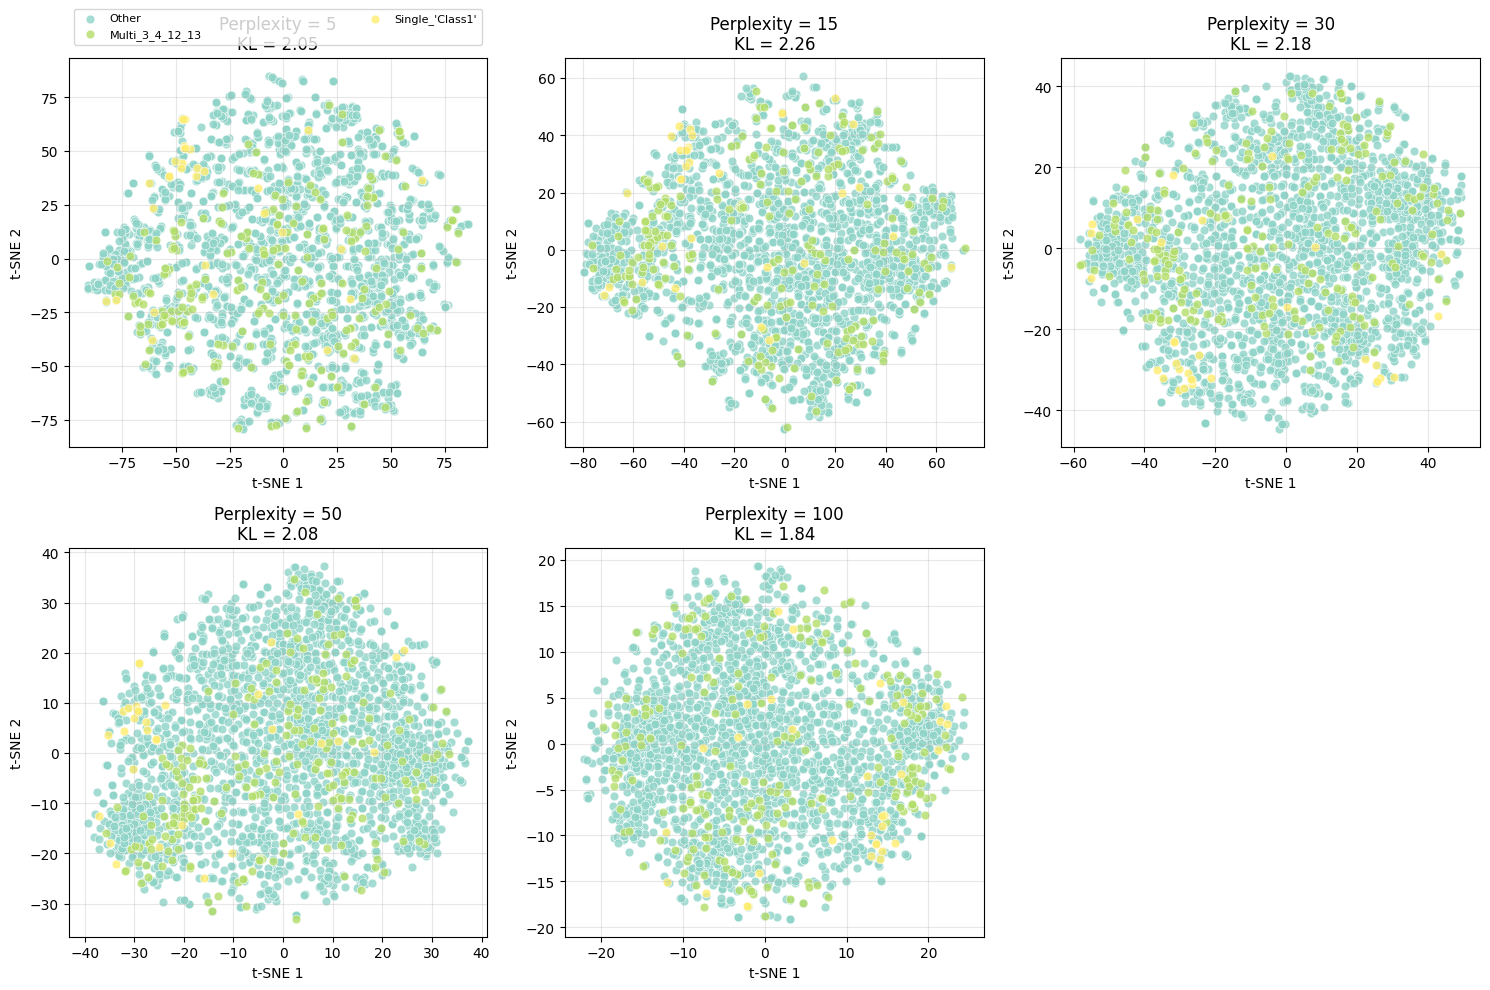

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def tsne_grid_experiment(X_scaled, target=None, perplexities=[5, 15, 30, 50, 100], random_state=42):
    """
    Create t-SNE subplots in a grid layout
    """
    
    n_perplexities = len(perplexities)
    
    # Calculate grid dimensions (aim for square-ish grid)
    n_cols = int(np.ceil(np.sqrt(n_perplexities)))
    n_rows = int(np.ceil(n_perplexities / n_cols))
    
    print(f"Creating {n_rows}x{n_cols} grid for {n_perplexities} perplexity values")
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    
    # Flatten axes array for easy indexing
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    tsne_results = {}
    kl_divergences = []
    
    for i, perplexity in enumerate(perplexities):
        print(f"Running t-SNE with perplexity={perplexity}...")
        
        # Apply t-SNE
        tsne = TSNE(n_components=2,
                   perplexity=perplexity,
                   random_state=random_state,
                   learning_rate='auto')
        
        X_tsne = tsne.fit_transform(X_scaled)
        tsne_results[perplexity] = X_tsne
        kl_divergences.append(tsne.kl_divergence_)
        
        ax = axes[i]
        
        if target is not None:
            # Color by target variable
            unique_targets = target.unique()
            colors = plt.cm.Set3(np.linspace(0, 1, len(unique_targets)))
            
            for j, target_class in enumerate(unique_targets):
                mask = target == target_class
                ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                         alpha=0.8, s=40, color=colors[j],
                         label=target_class, edgecolors='white', linewidth=0.5)
            
            # Add legend to first subplot only
            if i == 0:
                ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                         ncol=2, mode="expand", fontsize=8)
        else:
            # Uniform coloring
            ax.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.8, s=40, c=new_target, cmap='plasma')
        
        ax.set_title(f'Perplexity = {perplexity}\nKL = {tsne.kl_divergence_:.2f}', fontsize=12)
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')
        ax.grid(True, alpha=0.3)
        
        # Print statistics
        print(f"  KL Divergence: {tsne.kl_divergence_:.4f}")
        print(f"  Range: [{X_tsne[:, 0].min():.2f}, {X_tsne[:, 0].max():.2f}]")
    
    # Hide empty subplots
    for i in range(n_perplexities, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return tsne_results, kl_divergences


tsne_results, kl_divergences = tsne_grid_experiment(X_scaled, new_target, perplexities=[5, 15, 30, 50, 100])

C:\Users\Dell\AppData\Local\Temp\ipykernel_19084\1407897528.py:35: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if pd.factorize([labels[i]])[0][0] != majority:


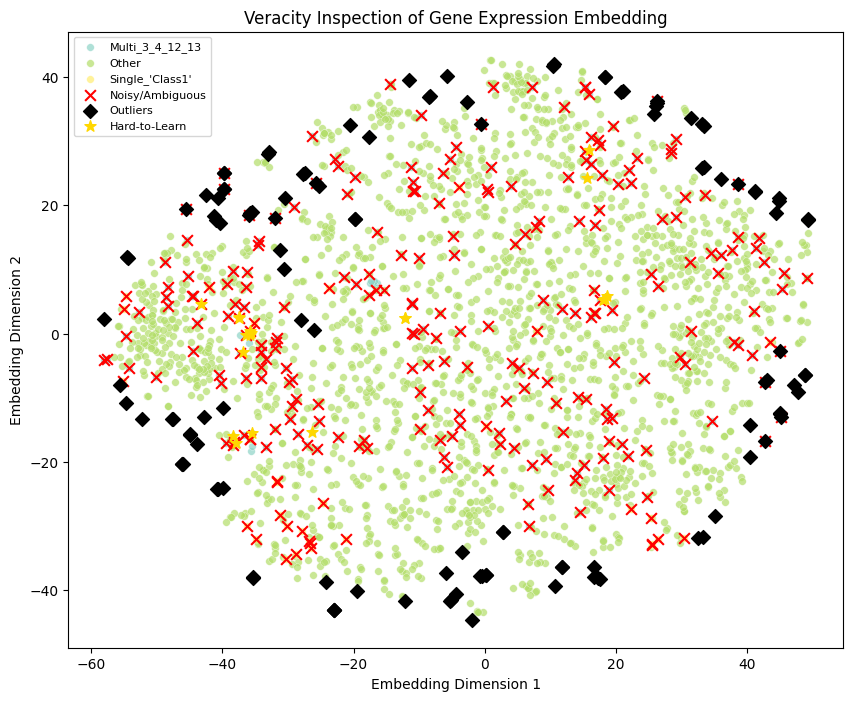

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Use X_isomap or X_tsne as embedding (choose one, e.g. X_isomap here)
X_tsne = tsne_results[30]
embedding = X_tsne  
labels = new_target.values  

plt.figure(figsize=(10,8))

# Plot all points
unique_targets = np.unique(labels)
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_targets)))

for j, target_class in enumerate(unique_targets):
    mask = labels == target_class
    plt.scatter(embedding[mask, 0], embedding[mask, 1],
                alpha=0.7, s=30, color=colors[j],
                label=target_class, edgecolors='white', linewidth=0.3)

# ------------------------
# 1. Detect noisy/ambiguous labels
# ------------------------
# Approximate: a point whose nearest neighbors mostly belong to another class
nbrs = NearestNeighbors(n_neighbors=10).fit(embedding)
_, indices = nbrs.kneighbors(embedding)

noisy_points = []
for i, neigh in enumerate(indices):
    neigh_labels = labels[neigh]
    # Convert to integers if not already
    neigh_labels_int = pd.factorize(neigh_labels)[0]
    majority = np.argmax(np.bincount(neigh_labels_int))
    if pd.factorize([labels[i]])[0][0] != majority:
        noisy_points.append(i)


plt.scatter(embedding[noisy_points,0], embedding[noisy_points,1],
            c='red', marker='x', s=60, label="Noisy/Ambiguous")

# ------------------------
# 2. Detect outliers
# ------------------------
# Outliers: points with large average distance to neighbors
distances, _ = nbrs.kneighbors(embedding)
avg_dist = distances.mean(axis=1)
threshold = np.percentile(avg_dist, 95)  # top 5% farthest
outliers = np.where(avg_dist > threshold)[0]

plt.scatter(embedding[outliers,0], embedding[outliers,1],
            c='black', marker='D', s=50, label="Outliers")
# ------------------------
# 3. Hard-to-learn samples
# ------------------------
hard_points = []
for i, neigh in enumerate(indices):
    neigh_labels = labels[neigh]
    # Convert to integer codes
    neigh_labels_int = pd.factorize(neigh_labels)[0]
    purity = np.max(np.bincount(neigh_labels_int)) / len(neigh_labels_int)
    if purity < 0.6:  # heavily mixed
        hard_points.append(i)
plt.scatter(embedding[hard_points,0], embedding[hard_points,1],
            c='gold', marker='*', s=70, label="Hard-to-Learn")

# ------------------------
# Finalize plot
# ------------------------
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.title("Veracity Inspection of Gene Expression Embedding")
plt.legend(loc="best", fontsize=8)
plt.show()


**t-SNE Analysis: Noisy Labels, Outliers & Hard-to-Learn Regions**

**Noisy/Ambiguous Labels**

Isolated Mismatches: Individual blue points embedded within orange/yellow clusters across multiple perplexities, indicating genes with similar expression patterns but different functional annotations.

Boundary Ambiguity: Significant mixing between yellow and green categories along their interface, suggesting overlapping expression patterns or inconsistent annotation boundaries.

Embedded Enclaves: Small groups of one color (green, red) deeply surrounded by different-colored clusters, particularly visible at mid-range perplexities (15-30).

Central Region Conflicts: Multiple color intermingling in central zones, revealing either labeling inconsistencies or genes participating in multiple biological processes.

**Outliers**
Upper-Right Solitary Point: Consistently isolated across all perplexities, likely representing a gene with unique regulatory mechanisms or novel function.

Lower-Left Isolates: Several distant points suggesting condition-specific genes not activated in most experiments, possibly stress-response or specialized metabolic genes.

Mini-Cluster Separation: Small groups (2-3 points) separated from main clusters, potentially indicating genes with chimeric expression patterns or recent evolutionary duplications.

**Hard-to-Learn Samples**

Central Mixed Zone: Thorough color mixing where expression patterns lack discriminative power, challenging classifiers due to pleiotropic genes or multi-functional proteins.

Blue-Purple Interface: Extensive boundary mixing where linear classifiers cannot find clear separation, indicating shared regulatory mechanisms between functional categories.

Lower-Right Ambiguity: Complete overlap of green, yellow, and orange points where expression features provide insufficient information for reliable category distinction.

**Key Biological Insights**

Perplexity 30 provides optimal visualization, balancing local and global structure

Mixed regions reveal limitations in categorical functional annotation systems

Outliers represent specialized genes or condition-specific expression patterns

Hard-to-learn areas highlight inherent ambiguities in gene function prediction from expression data alone

These findings suggest that simple classifiers will struggle with the biologically complex nature of gene function relationships, necessitating more sophisticated approaches that can handle functional overlaps and annotation uncertainties.



## PART C

In [16]:


# Assume X is your scaled feature matrix
isomap = Isomap(n_components=2, n_neighbors=5)   # n_neighbors is tunable
X_isomap = isomap.fit_transform(X_scaled)


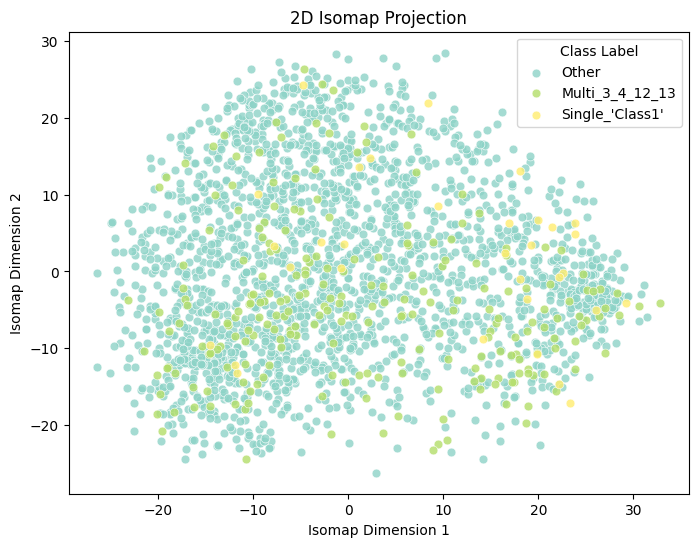

In [17]:
unique_targets = new_target.unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_targets)))

plt.figure(figsize=(8,6))
for j, target_class in enumerate(unique_targets):
    mask = new_target == target_class
    plt.scatter(X_isomap[mask, 0], X_isomap[mask, 1],
                alpha=0.8, s=40, color=colors[j],
                label=target_class, edgecolors='white', linewidth=0.5)

plt.xlabel("Isomap Dimension 1")
plt.ylabel("Isomap Dimension 2")
plt.title("2D Isomap Projection")
plt.legend(title="Class Label")   # Legend instead of colorbar
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_19084\1421042526.py:30: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  if pd.factorize([labels[i]])[0][0] != majority:


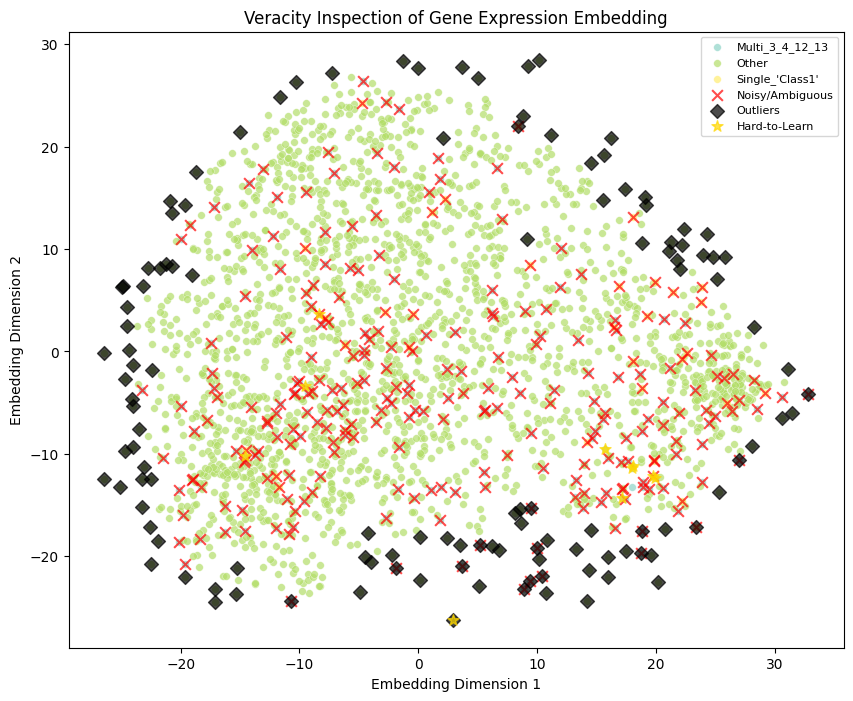

In [23]:

# Use X_isomap or X_tsne as embedding (choose one, e.g. X_isomap here)
embedding = X_isomap  
labels = new_target.values  

plt.figure(figsize=(10,8))

# Plot all points
unique_targets = np.unique(labels)
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_targets)))

for j, target_class in enumerate(unique_targets):
    mask = labels == target_class
    plt.scatter(embedding[mask, 0], embedding[mask, 1],
                alpha=0.7, s=30, color=colors[j],
                label=target_class, edgecolors='white', linewidth=0.3)

# ------------------------
# 1. Detect noisy/ambiguous labels
# ------------------------
# Approximate: a point whose nearest neighbors mostly belong to another class
nbrs = NearestNeighbors(n_neighbors=10).fit(embedding)
_, indices = nbrs.kneighbors(embedding)

noisy_points = []
for i, neigh in enumerate(indices):
    neigh_labels = labels[neigh]
    # Convert to integers if not already
    neigh_labels_int = pd.factorize(neigh_labels)[0]
    majority = np.argmax(np.bincount(neigh_labels_int))
    if pd.factorize([labels[i]])[0][0] != majority:
        noisy_points.append(i)


plt.scatter(embedding[noisy_points,0], embedding[noisy_points,1],
            c='red', marker='x', s=60, label="Noisy/Ambiguous", alpha=0.7)

# ------------------------
# 2. Detect outliers
# ------------------------
# Outliers: points with large average distance to neighbors
distances, _ = nbrs.kneighbors(embedding)
avg_dist = distances.mean(axis=1)
threshold = np.percentile(avg_dist, 95)  # top 5% farthest
outliers = np.where(avg_dist > threshold)[0]

plt.scatter(embedding[outliers,0], embedding[outliers,1],
            c='black', marker='D', s=50, label="Outliers", alpha=0.7)
# ------------------------
# 3. Hard-to-learn samples
# ------------------------
hard_points = []
for i, neigh in enumerate(indices):
    neigh_labels = labels[neigh]
    # Convert to integer codes
    neigh_labels_int = pd.factorize(neigh_labels)[0]
    purity = np.max(np.bincount(neigh_labels_int)) / len(neigh_labels_int)
    if purity < 0.6:  # heavily mixed
        hard_points.append(i)
plt.scatter(embedding[hard_points,0], embedding[hard_points,1],
            c='gold', marker='*', s=70, label="Hard-to-Learn", alpha=0.7)

# ------------------------
# Finalize plot
# ------------------------
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.title("Veracity Inspection of Gene Expression Embedding")
plt.legend(loc="best", fontsize=8)
plt.show()


**Key Observations**

**1. Class Separation Quality**
- The **"Multi_3_4_12_13"** class (light blue) forms a relatively cohesive cluster in the central region, suggesting these samples share similar gene expression patterns
- **"Outliers"** (black diamonds) are distributed around the periphery, particularly concentrated in the upper-right and lower portions - this is expected behavior for anomalous samples
- **"Single 'Class1'"** samples (green) are widely dispersed throughout the embedding space, indicating high internal variability

**2. Problematic Regions**
- **"Noisy/Ambiguous"** samples (red X's) are scattered throughout, often interspersed with other classes. This distribution suggests:
  - These samples have inconsistent or unclear gene expression signatures
  - They may represent transition states or mixed phenotypes
  - The embedding cannot cleanly separate them from other groups

**3. Learning Challenges**
- The **"Hard-to-Learn"** sample (yellow diamond, bottom center) sits in a relatively isolated position, suggesting its gene expression profile is genuinely distinct from typical patterns

**Manifold Structure Interpretation**

The Isomap embedding reveals:
- **Non-linear relationships**: The curved distribution suggests gene expression space has complex, non-linear structure
- **No clear linear separability**: Classes overlap substantially, indicating that simple linear classifiers would struggle
- **Potential substructure**: Some clustering within the "Multi" class hints at possible subtypes

**Implications**

This embedding suggests the dataset would benefit from either more sophisticated classification methods or that the labeling scheme may need refinement to better capture the underlying biological heterogeneity.

**Comparison of Isomap vs. t-SNE visualizations**

**Isomap plot (top figure):**
- Points are spread out across the 2D plane in a fairly continuous way
- Does not form distinct, tight clusters
- Tries to preserve global geometry (geodesic distances), resulting in a more "unrolled" and smooth distribution
- Better at capturing the global structure of gene expression data — how all samples relate to each other in the bigger picture

**t-SNE plots (bottom figure, with different perplexities):**
- Forms localized clusters of points regardless of perplexity
- Relative distances between clusters are not reliable (clusters can appear close or far depending on initialization/perplexity)
- Excels at revealing local structure (which samples are most similar)
- Does not preserve global relationships across the dataset

**Answer (first part):**
- Isomap is better at revealing the global structure of the gene expression data because:
  - It preserves geodesic distances
  - It shows how points are distributed across the full manifold
- t-SNE, in contrast:
  - Highlights local neighborhoods and clusters
  - Distorts global geometry


**Data manifold, curvature, and classification difficulty**

**What is a data manifold:**
- Although data may live in high-dimensional space (thousands of gene expression features), samples actually lie on or near a lower-dimensional surface (manifold) that captures the true variability

**Observations from the Isomap plot:**
- Points are spread out and overlapping, without clear linear separation
- This suggests the manifold is highly curved and complex, not flat
- Gene expression data doesn't sit on a simple 2D plane but instead on a nonlinear surface embedded in high dimensions

**Implications for classification:**
- Simple classifiers (like linear models) will struggle if the manifold is curved and tangled
- Classes cannot be separated by straight lines
- More complex models may be required to follow the curvature of the manifold and achieve good accuracy:
  - Kernel methods
  - Ensemble methods
  - Deep learning

**Answer (second part):**
- The Isomap visualization suggests the data lies on a highly curved and complex manifold, as indicated by:
  - The continuous but tangled spread of points
- This complexity makes classification more difficult because:
  - Decision boundaries must follow the nonlinear geometry of the manifold
  - Simple straight decision boundaries are insufficient
